In [1]:
import mne
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:

raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])


Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:

annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations2.csv")


annotations_df = annotations_df[annotations_df['description'] != 'ignore']


annotations_df['onset'] = annotations_df['onset'] / 1e9


Generated Events:
[[ 20000      0      1]
 [ 21250      0      1]
 [ 22500      0      1]
 [ 23750      0      1]
 [ 25000      0      1]
 [ 26250      0      1]
 [ 27500      0      1]
 [ 28750      0      1]
 [ 30000      0      1]
 [ 31250      0      1]
 [ 32500      0      1]
 [ 33750      0      1]
 [ 35000      0      1]
 [ 36250      0      1]
 [ 56250      0      2]
 [ 57500      0      2]
 [ 58750      0      2]
 [ 60000      0      2]
 [ 61250      0      2]
 [ 62500      0      2]
 [ 63750      0      2]
 [ 65000      0      2]
 [ 66250      0      2]
 [ 67500      0      2]
 [ 68750      0      2]
 [ 85000      0      1]
 [ 86250      0      1]
 [ 87500      0      1]
 [ 88750      0      1]
 [ 90000      0      1]
 [ 91250      0      1]
 [ 92500      0      1]
 [ 93750      0      1]
 [ 95000      0      1]
 [ 96250      0      1]
 [ 97500      0      1]
 [ 98750      0      1]
 [100000      0      1]
 [101250      0      1]
 [102500      0      1]
 [103750      0      1

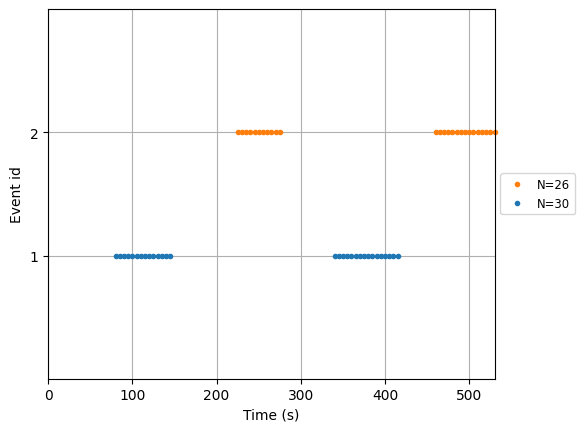

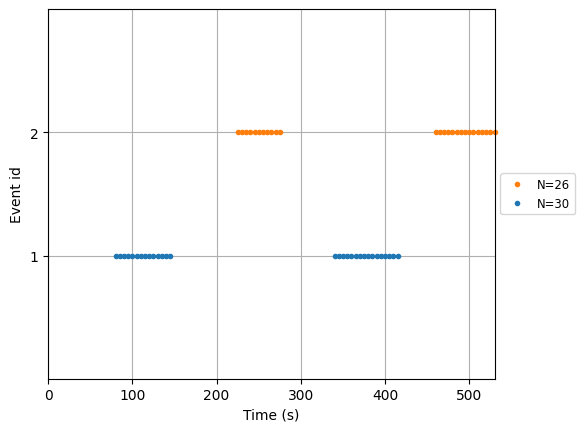

In [4]:

emotional_states = {'happy': 1, 'sad': 2}


events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)


mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


In [5]:

event_id = {'happy': 1, 'sad': 2}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=5, baseline=None)



Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated


In [6]:
#psd
def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)


X = eeg_power_band(epochs)
y = epochs.events[:, 2]


Loading data for 56 events and 1251 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


In [7]:

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())


split_idx = int(len(X) * 0.56)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())


Class distribution in the dataset:
1    30
2    26
Name: count, dtype: int64
Class distribution in the training set:
1    20
2    11
Name: count, dtype: int64
Class distribution in the test set:
2    15
1    10
Name: count, dtype: int64


In [8]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Accuracy score: 0.68
Confusion Matrix:
[[8 2]
 [6 9]]


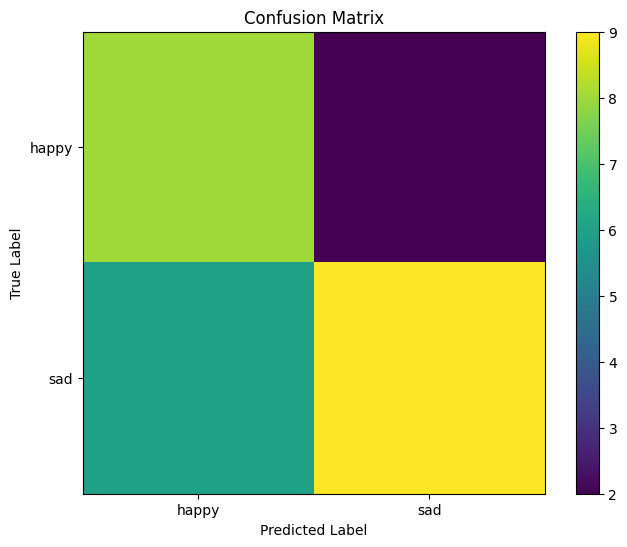

In [9]:

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy score: {acc}")
print(f"Confusion Matrix:\n{conf_matrix}")


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['happy', 'sad'])
plt.yticks([0, 1], ['happy', 'sad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
